In [82]:
#imports

import sys
print(sys.executable)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.table import Table
import torch
from pathlib import Path
import rasterio
from utils import augmentations, geofiles




/scratch2/Arno_MT/MT_env/bin/python


In [83]:
examples_losses = torch.load("examples/examples_losses.pth")
print(examples_losses[-1])

examples_metrics = torch.load("examples/examples_metrics.pth")
print(examples_metrics[0])


('losangeles', '0000007168-0000005632', 0.2672649025917053, 0.31095200777053833, 0.2852606177330017, 0.16573989391326904, 1.0292174220085144)
('phoenix', '0000006656-0000002048', 1.0, 0.21052631735801697, 0.0, 1.0, 1.0, 0.0, 1.0, 0.3478260934352875, 0.0, 1.0, 0.21052631735801697, 0.0, 0.9986706972122192, 0.0005669202655553818, 0.9939745664596558)


In [84]:
def _get_sentinel1_data(site, patch_id):
    file = Path('../GM12_GUM/' + site + f'/sentinel1/sentinel1_{site}_{patch_id}.tif')
    img, transform, crs = geofiles.read_tif(file)
    return np.nan_to_num(img).astype(np.float32), transform, crs

def _get_sentinel2_data(site, patch_id):
    file = Path('../GM12_GUM/' + site + f'/sentinel2/sentinel2_{site}_{patch_id}.tif')
    img, transform, crs = geofiles.read_tif(file)
    return np.nan_to_num(img).astype(np.float32), transform, crs

def _get_label_data(site, patch_id):
    label = "buildings"
    label_file = Path("../GM12_GUM/" + site + "/" + label + f'/{label}_{site}_{patch_id}.tif')
    img, transform, crs = geofiles.read_tif(label_file)
    img = img > 0
    return np.nan_to_num(img).astype(np.float32), transform, crs

def _get_pred_data(site, patch_id):
    file = Path('../GM12_GUM/' + site + f'/predictions_KTH/prediction_fusion_{patch_id}.tif')
    pred_fusion, transform, crs = geofiles.read_tif(file)
    file = Path('../GM12_GUM/' + site + f'/predictions_KTH/prediction_SAR_{patch_id}.tif')
    pred_SAR, _, _ = geofiles.read_tif(file)
    file = Path('../GM12_GUM/' + site + f'/predictions_KTH/prediction_optical_{patch_id}.tif')
    pred_optical, _, _ = geofiles.read_tif(file)
    return np.nan_to_num(pred_fusion).astype(np.float32), np.nan_to_num(pred_SAR).astype(np.float32), np.nan_to_num(pred_optical).astype(np.float32), transform, crs

def get_rgb(x):

    quantile = 99

    rgb = np.flip(x[:,:,:3],axis=2)

    maxi = np.percentile(rgb[:,:,0].flatten(),quantile)
    mini = np.percentile(rgb[:,:,0].flatten(),100-quantile)
    rgb[:,:,0] = np.where(rgb[:,:,0] > maxi, maxi, rgb[:,:,0])
    rgb[:,:,0] = np.where(rgb[:,:,0] < mini, mini, rgb[:,:,0])
    rgb[:,:,0] = (rgb[:,:,0]-mini)/(maxi-mini)

    maxi = np.percentile(rgb[:,:,1].flatten(),quantile)
    mini = np.percentile(rgb[:,:,1].flatten(),100-quantile)
    rgb[:,:,1] = np.where(rgb[:,:,1] > maxi, maxi, rgb[:,:,1])
    rgb[:,:,1] = np.where(rgb[:,:,1] < mini, mini, rgb[:,:,1])
    rgb[:,:,1] = (rgb[:,:,1]-mini)/(maxi-mini)

    maxi = np.percentile(rgb[:,:,2].flatten(),quantile)
    mini = np.percentile(rgb[:,:,2].flatten(),100-quantile)
    rgb[:,:,2] = np.where(rgb[:,:,2] > maxi, maxi, rgb[:,:,2])
    rgb[:,:,2] = np.where(rgb[:,:,2] < mini, mini, rgb[:,:,2])
    rgb[:,:,2] = (rgb[:,:,2]-mini)/(maxi-mini)

    return rgb



denver 0000005120-0000000768


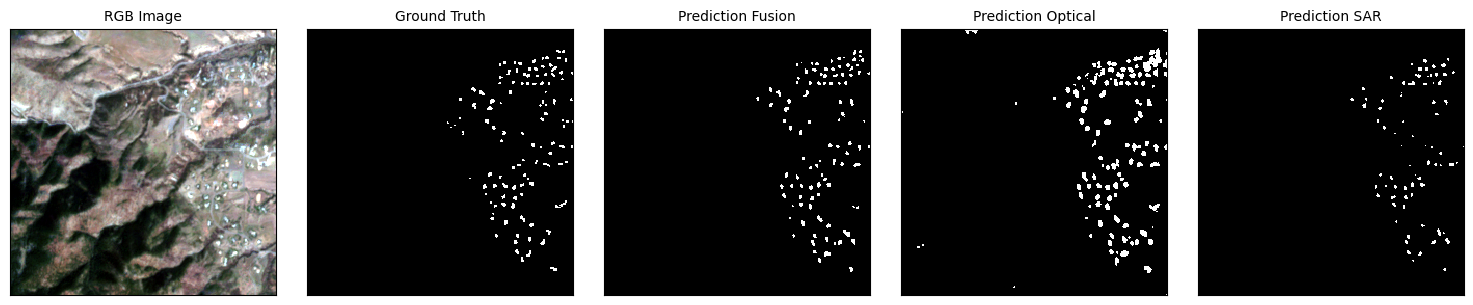

toronto 0000007168-0000000512


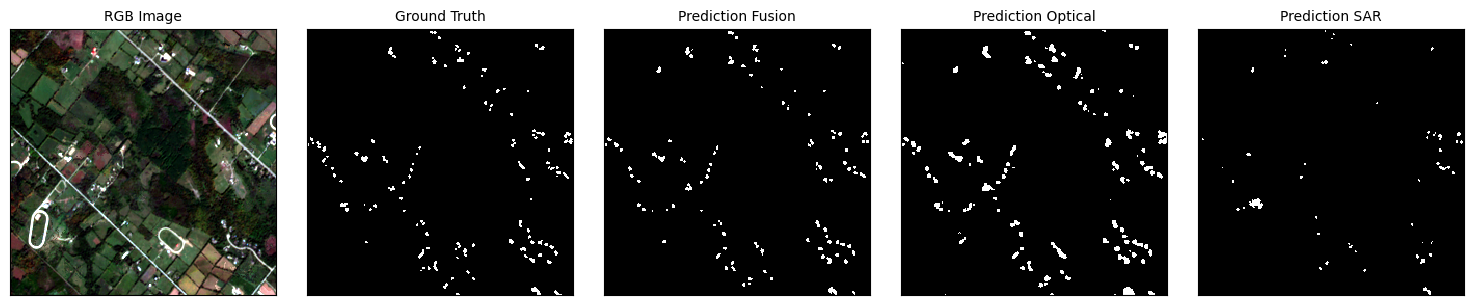

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dallas 0000008448-0000011520


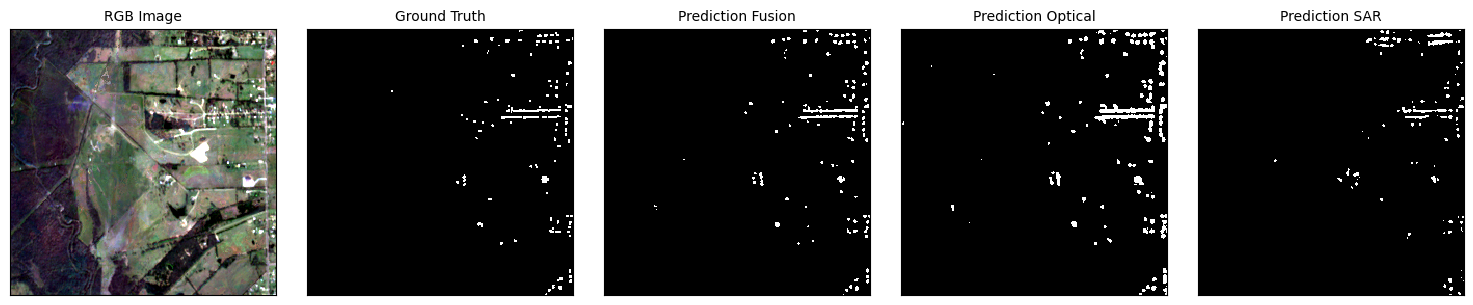

kansascity 0000006912-0000002304


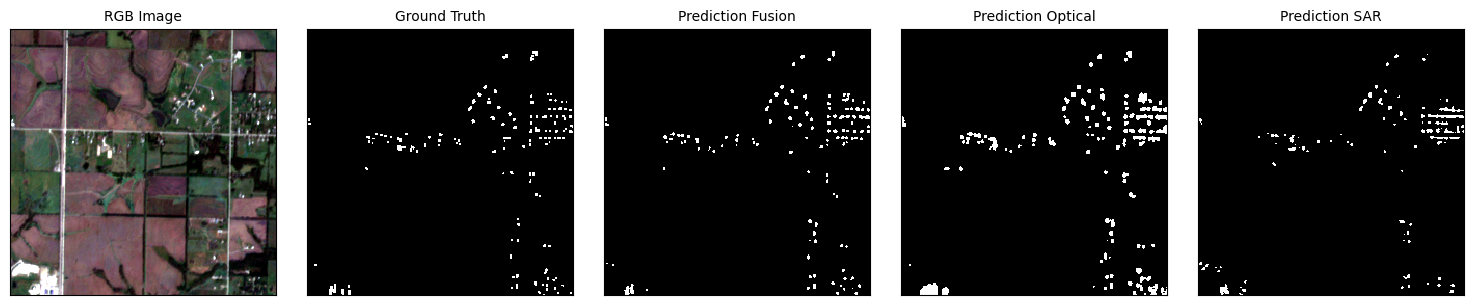

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


houston 0000000256-0000006912


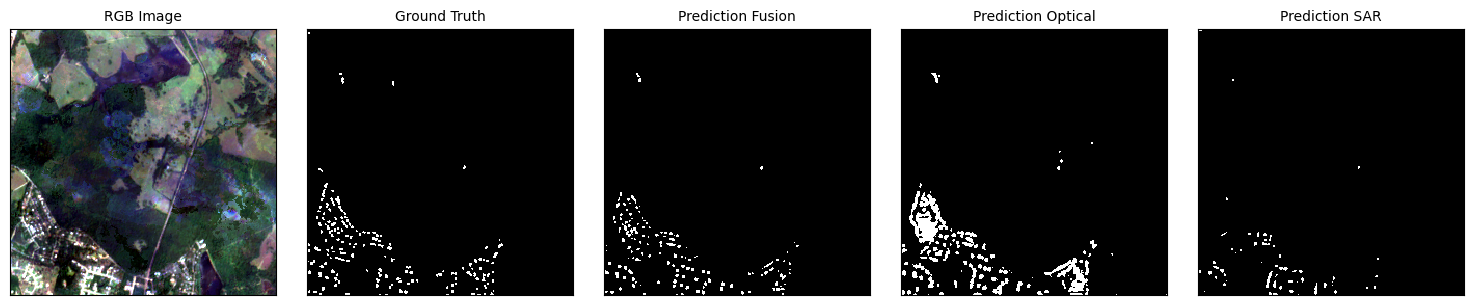

houston 0000005632-0000011776


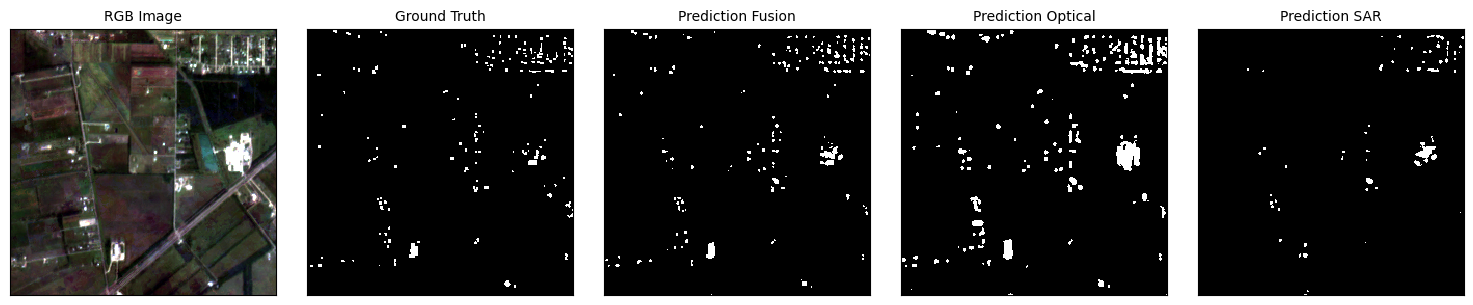

phoenix 0000005376-0000000512


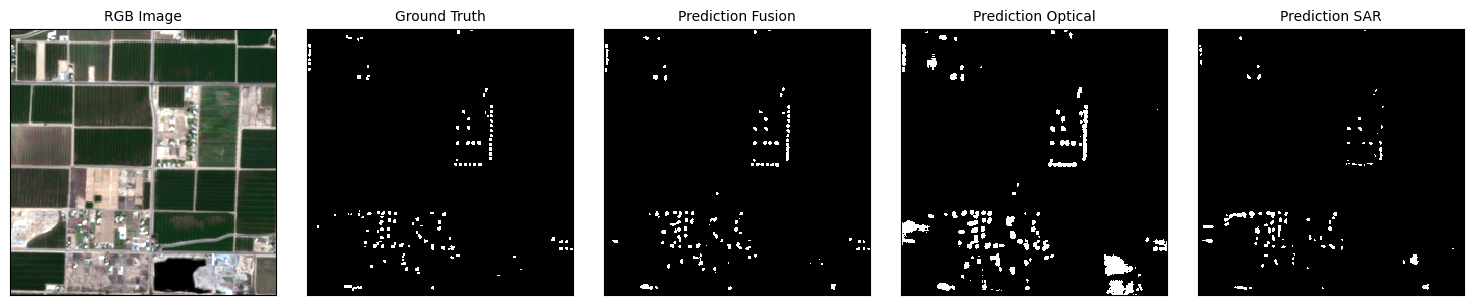

phoenix 0000004352-0000000768


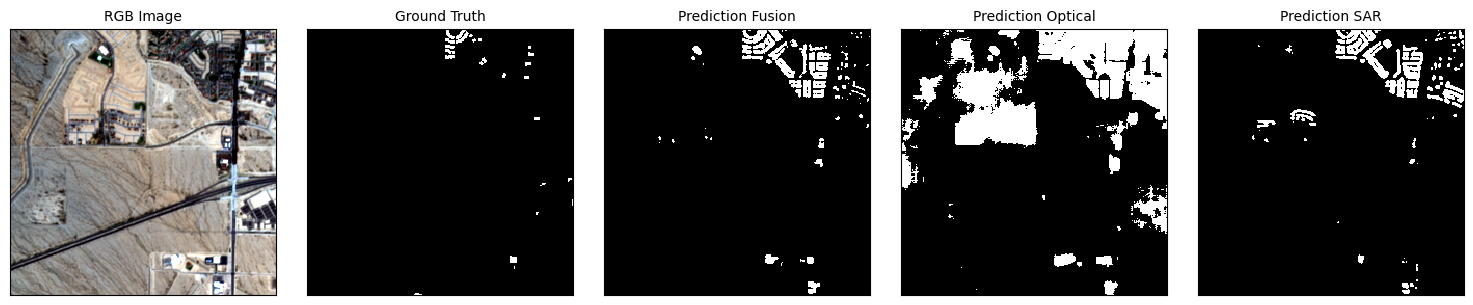

columbus 0000005376-0000003072


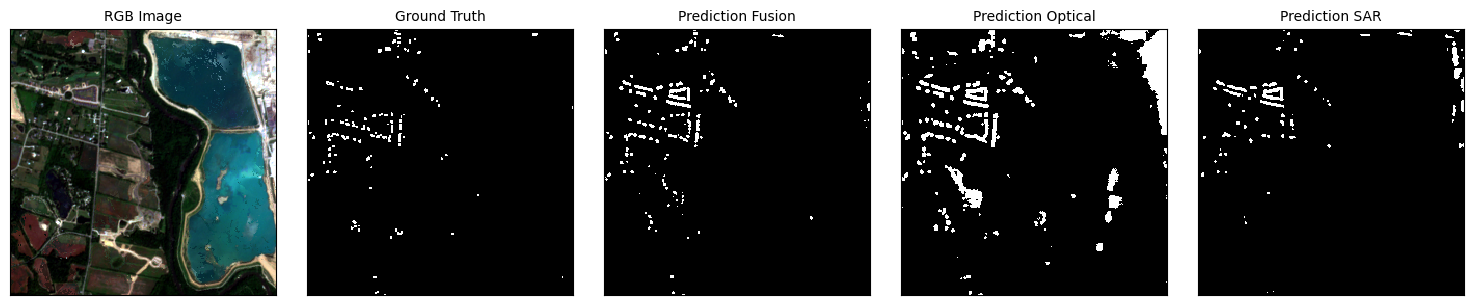

houston 0000011520-0000004864


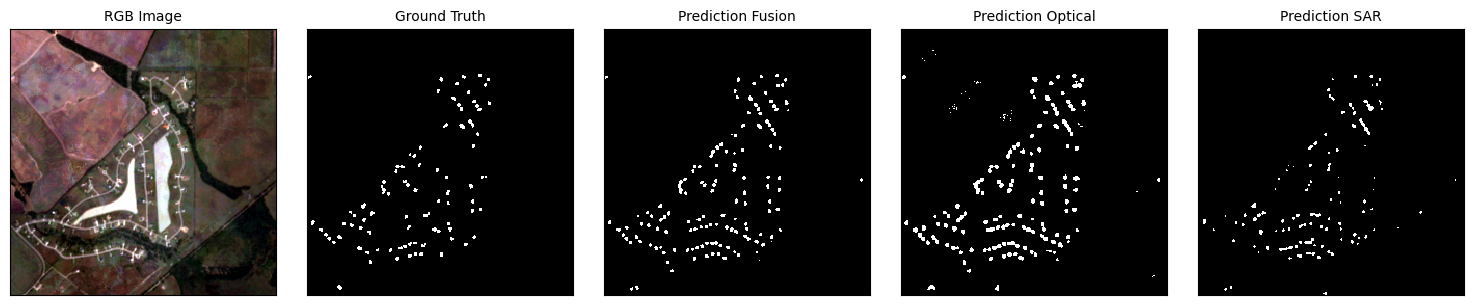

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


winnipeg 0000000256-0000003328


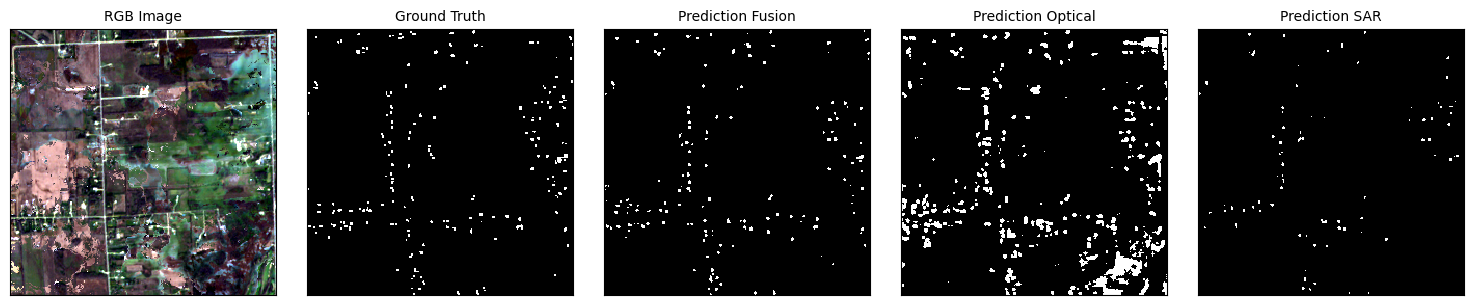

houston 0000005120-0000002304


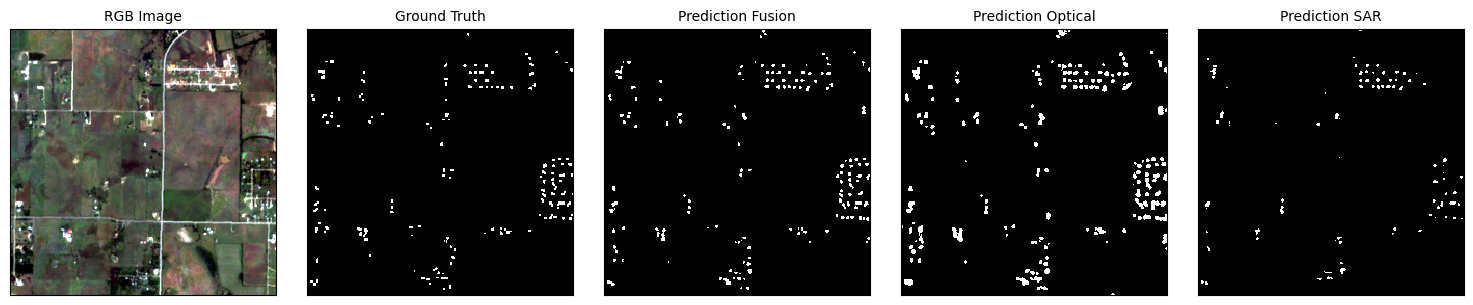

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sydney 0000004352-0000001280


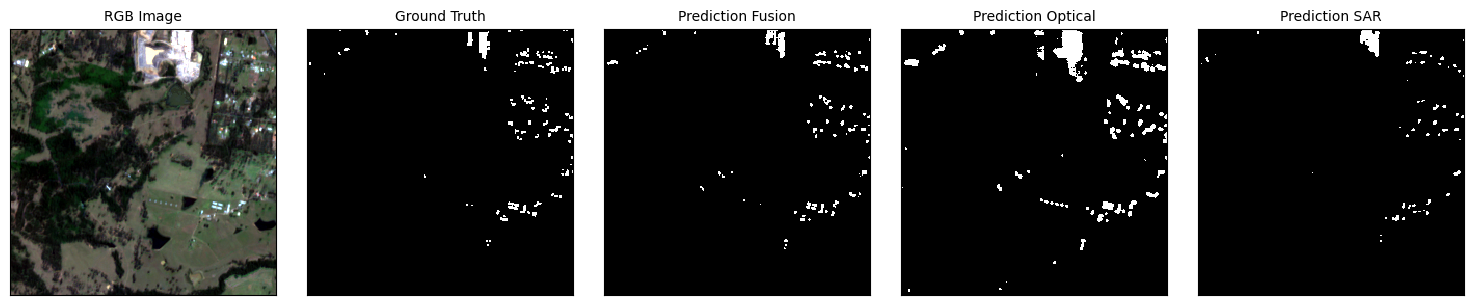

losangeles 0000000512-0000008192


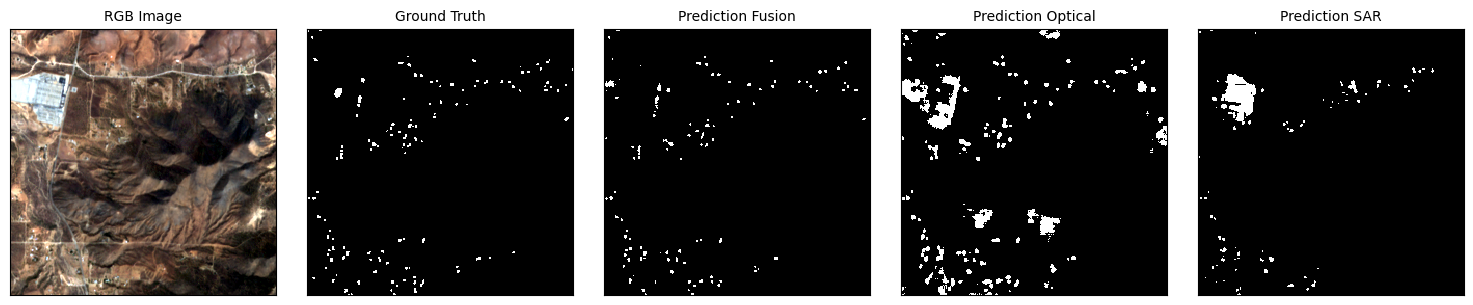

toronto 0000006656-0000002048


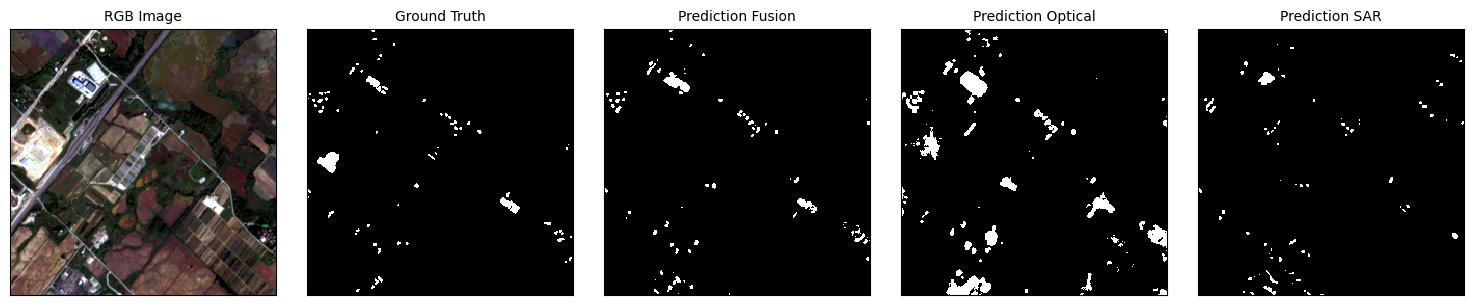

toronto 0000007936-0000001792


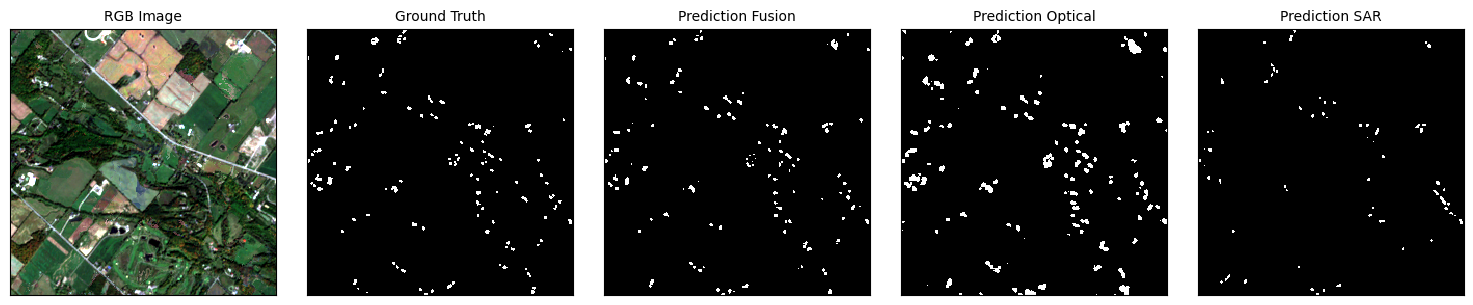

atlantaeast 0000007680-0000003328


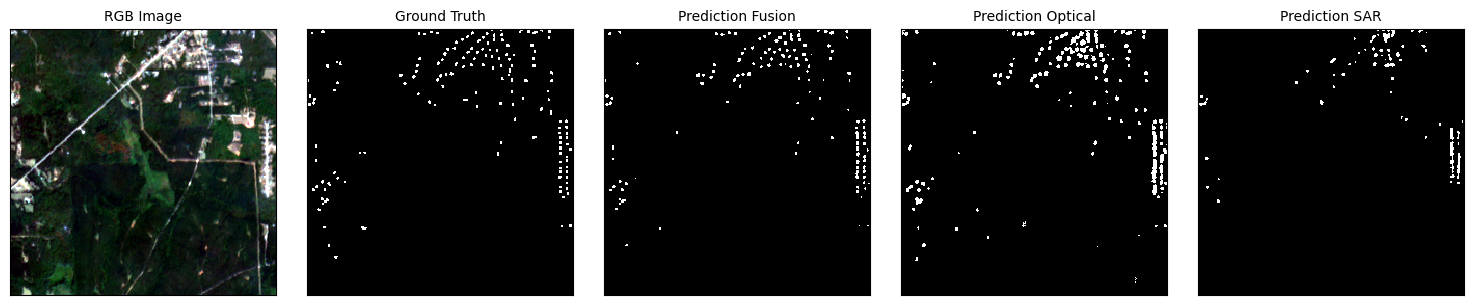

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


losangeles 0000005120-0000022272


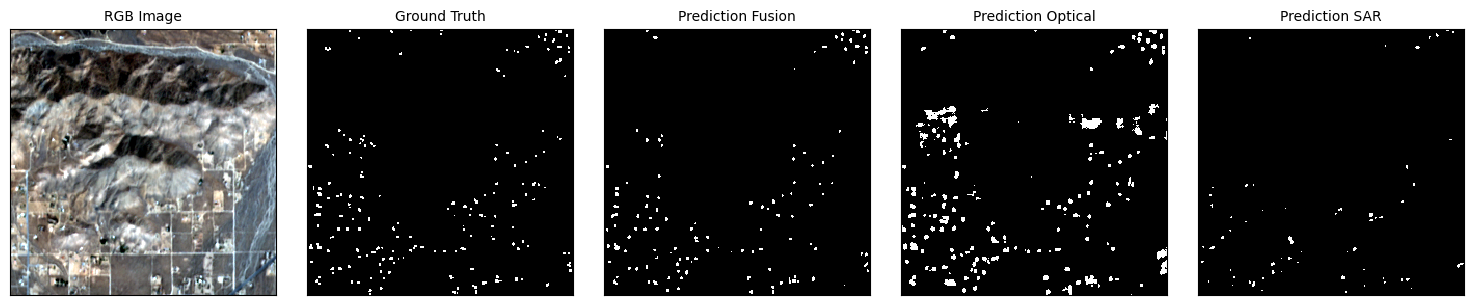

dallas 0000007168-0000008192


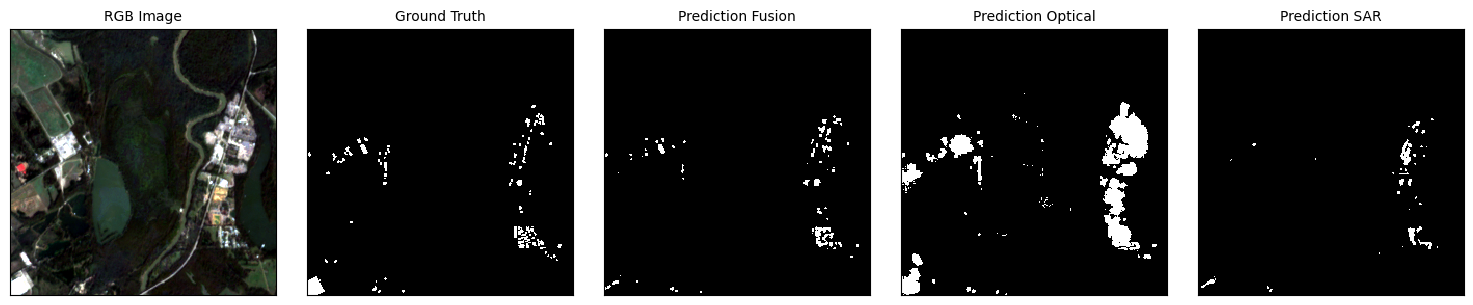

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


seattle 0000001024-0000003328


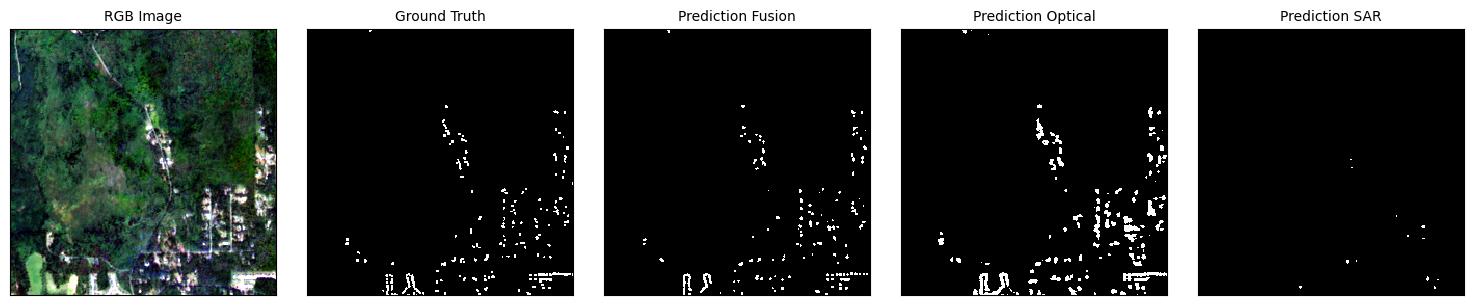

houston 0000011520-0000011776


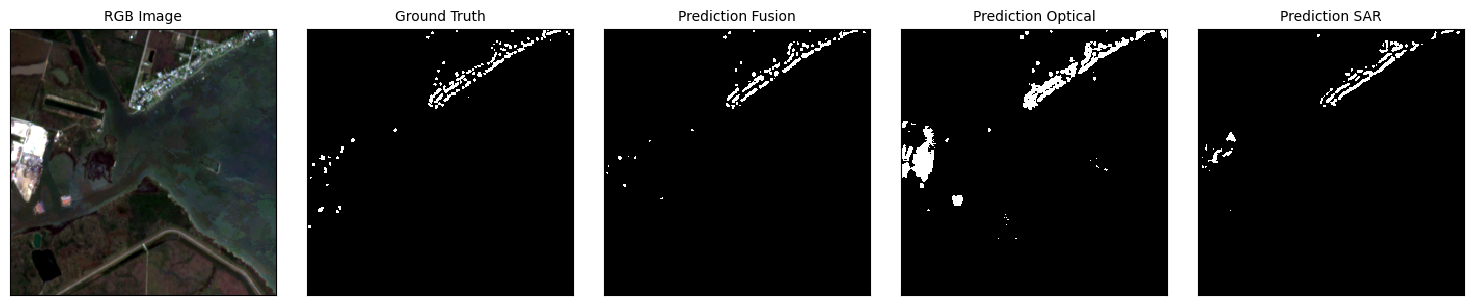

toronto 0000006656-0000001536


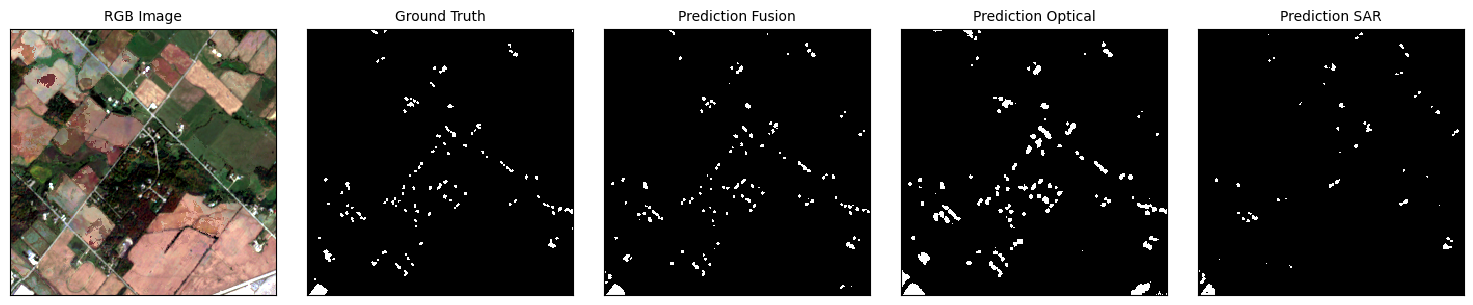

losangeles 0000002048-0000005376


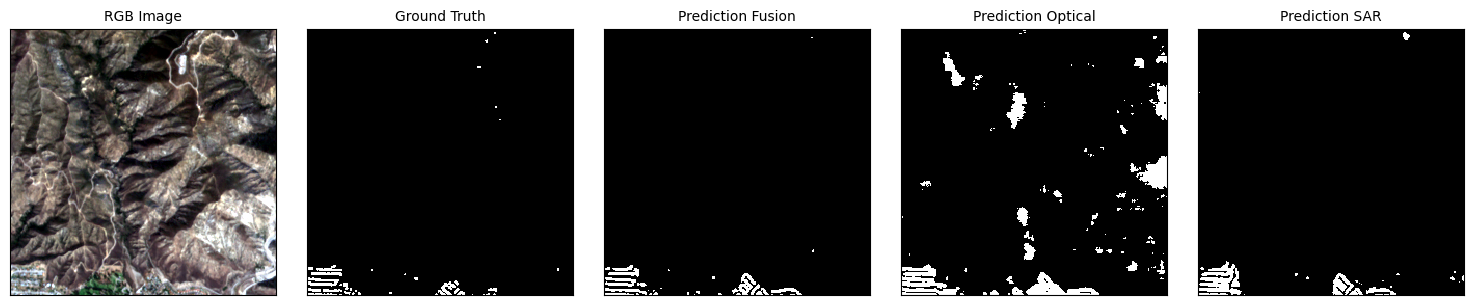

dallas 0000001280-0000002048


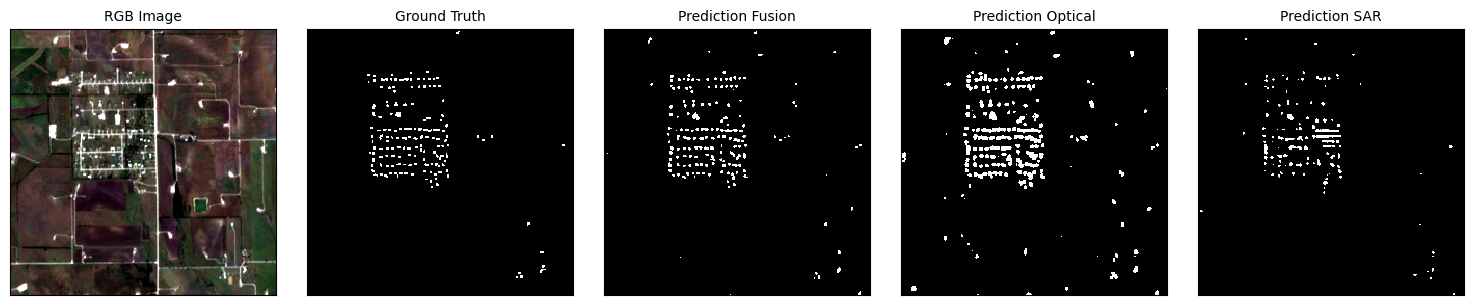

seattle 0000000768-0000003072


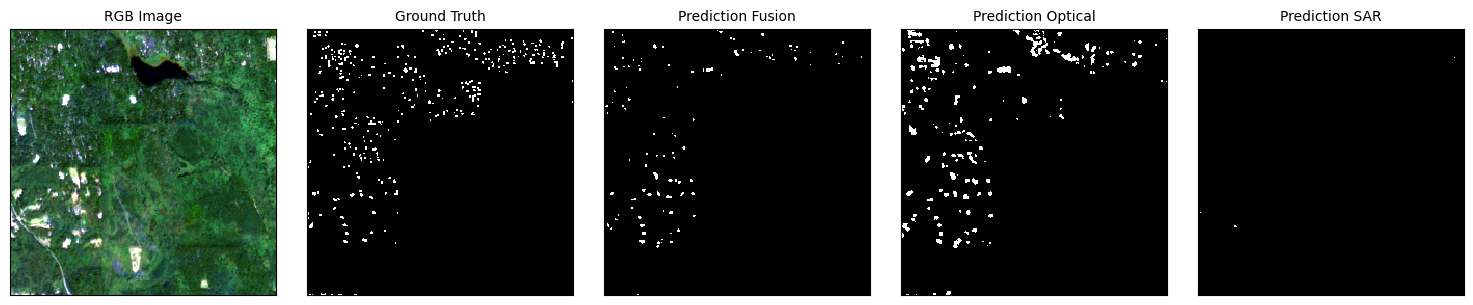

dallas 0000003840-0000011776


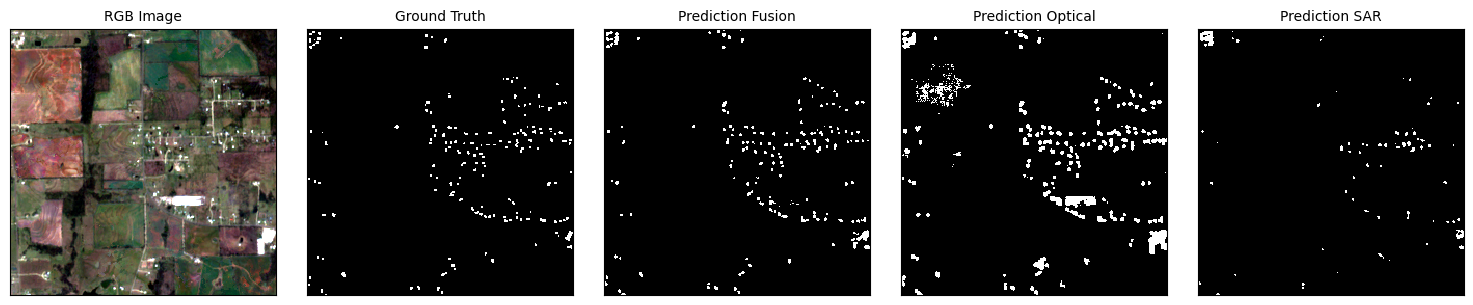

dallas 0000001024-0000010240


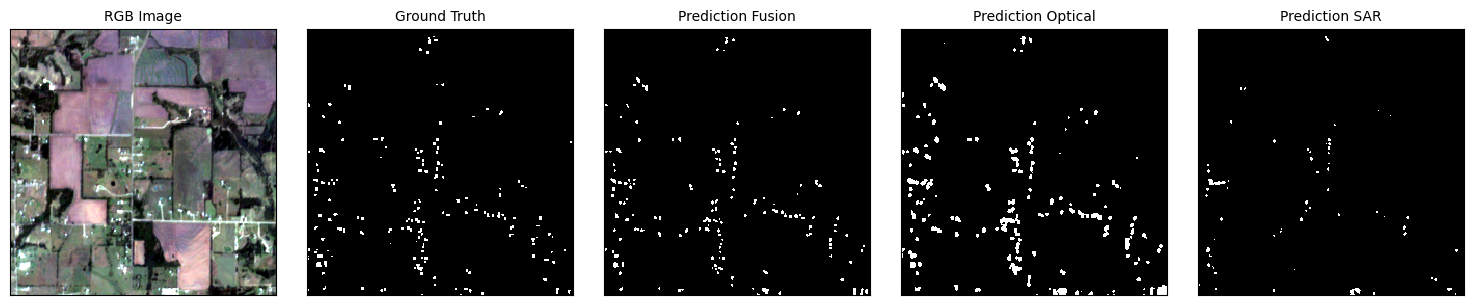

houston 0000004096-0000001536


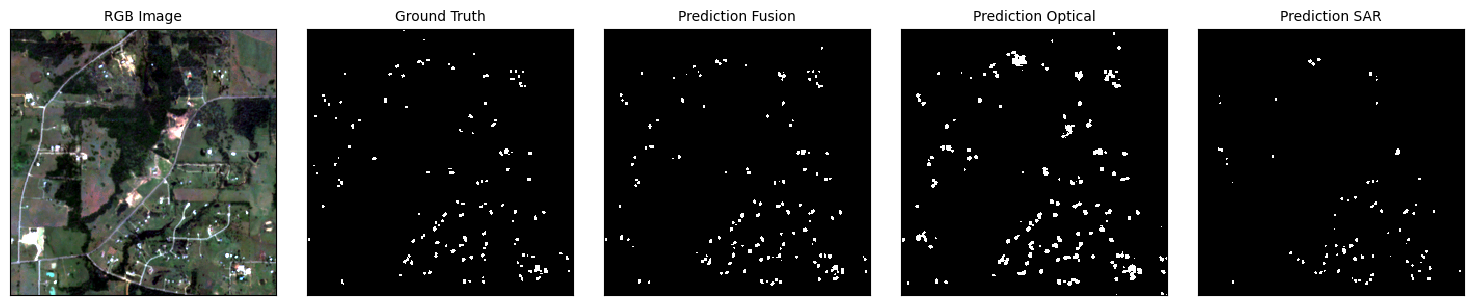

kansascity 0000002048-0000006144


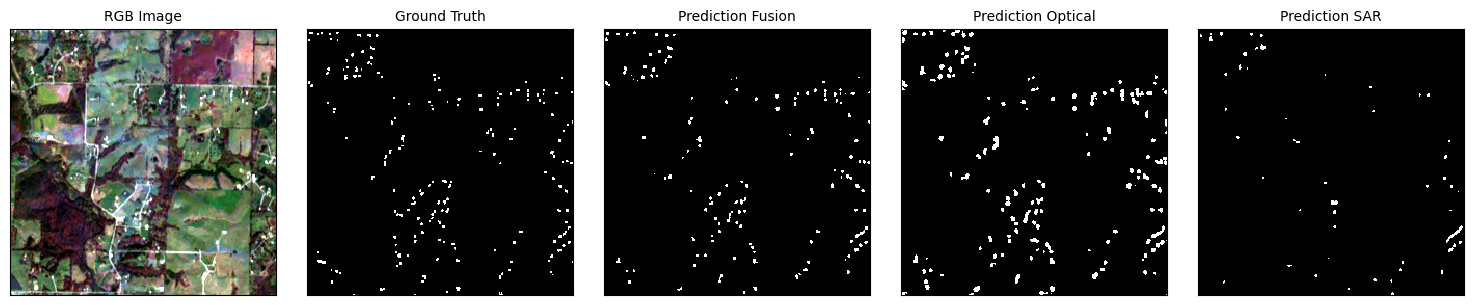

houston 0000012288-0000006656


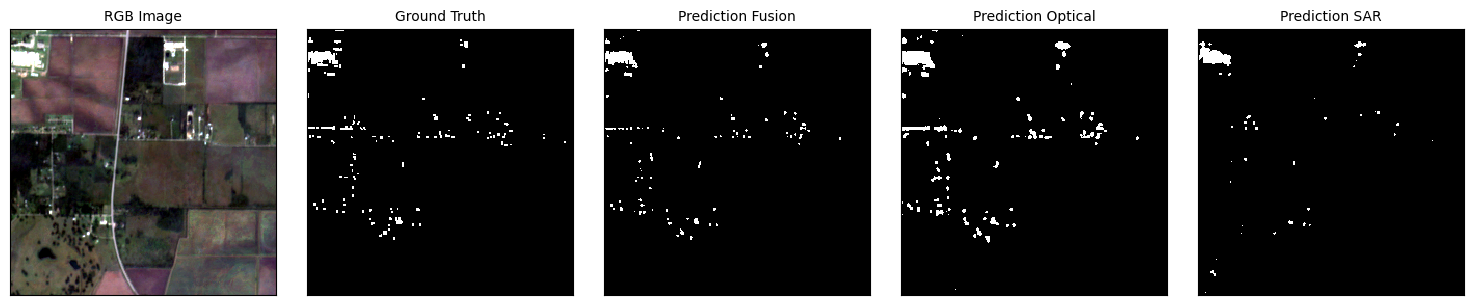

In [85]:

metric = "total_loss"
bestorworst = "best"
num_examples = 30
offset = 12583

if metric in ["fusion_loss", "optical_loss","sar_loss","consistency_loss", "total_loss"]:
    ind = ["fusion_loss", "optical_loss","sar_loss","consistency_loss", "total_loss"].index(metric) + 2
    examples_losses.sort(key=lambda x: x[ind], reverse=False)
    if bestorworst=="best":
        examples = examples_losses[offset:num_examples+offset]
    else:
        examples = examples_losses[-num_examples-offset:-offset]

if metric in ["prec_fusion", "prec_OPT", "prec_SAR", "rec_fusion", "rec_OPT", "rec_SAR",
                "f1_fusion","f1_OPT","f1_SAR","IoU_fusion","IoU_OPT","IoU_SAR","ssim_fusion","ssim_OPT","ssim_SAR"]:
    ind = ["prec_fusion", "prec_OPT", "prec_SAR", "rec_fusion", "rec_OPT", "rec_SAR",
           "f1_fusion","f1_OPT","f1_SAR","IoU_fusion","IoU_OPT","IoU_SAR","ssim_fusion","ssim_OPT","ssim_SAR"].index(metric) + 2
    examples_metrics.sort(key=lambda x: x[ind], reverse=True)
    if bestorworst=="best":
        examples = examples_metrics[offset:num_examples+offset]
    else:
        examples = examples_metrics[-num_examples-offset:-offset]

#examples = examples_metrics[19000:19010]


image_names = ['RGB Image', 'Ground Truth', 'Prediction Fusion', 'Prediction Optical', 'Prediction SAR']
metrics = ['Precision: ', 'Recall: ', 'F1-score: ', 'IoU: ', 'SSIM: ']

for example in examples:

    print(example[0], example[1])
    sen1,_,_ = _get_sentinel1_data(example[0], example[1])
    sen2,_,_ = _get_sentinel2_data(example[0], example[1])
    label,_,_ = _get_label_data(example[0], example[1])
    pred_fusion, pred_sar, pred_optical,_,_ = _get_pred_data(example[0], example[1])

    images = [get_rgb(sen2), label, pred_fusion>0.5, pred_optical>0.5, pred_sar>0.5]
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))

    # Iterate over the images and plot them in each subplot
    for i, image in enumerate(images):
        axes[i].imshow(image, interpolation="nearest", cmap="Greys_r")
        #axes[i].axis('off')
        # Remove the ticks
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        
        # Add the image names and titles
        axes[i].set_title(image_names[i], fontsize=10)
        
        if metric in ["prec_fusion", "prec_OPT", "prec_SAR", "rec_fusion", "rec_OPT", "rec_SAR",
                "f1_fusion","f1_OPT","f1_SAR","IoU_fusion","IoU_OPT","IoU_SAR","ssim_fusion","ssim_OPT","ssim_SAR"]:
            if i >= 2:
                k=i-2
                # Create a table with the metrics
                table_data = [
                    [metrics[0], "{:.2f}".format(example[2+k])],
                    [metrics[1], "{:.2f}".format(example[5+k])],
                    [metrics[2], "{:.2f}".format(example[8+k])],
                    [metrics[3], "{:.2f}".format(example[11+k])],
                    [metrics[4], "{:.2f}".format(example[14+k])],
                ]
                table = axes[i].table(cellText=table_data, cellLoc='center', loc='bottom', bbox=[0, -0.6, 1, 0.5])

                # Style the table
                table.auto_set_font_size(True)
                #table.set_fontsize(8)
                table.scale(1, 1.5)

                # Add the table to the plot
                axes[i].add_table(table)


    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the plot for a report
    #plt.savefig('report_plot.png', dpi=300)

    # Display the plot
    plt.show()


prec_fusion


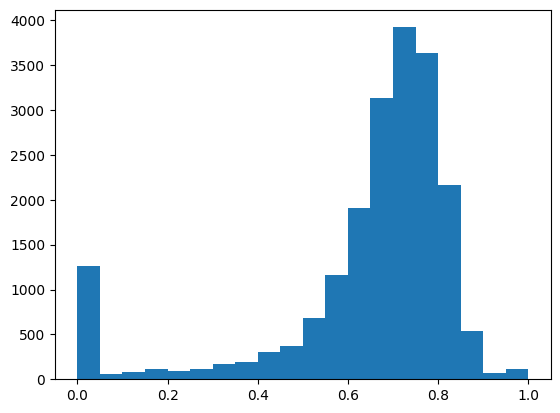

prec_OPT


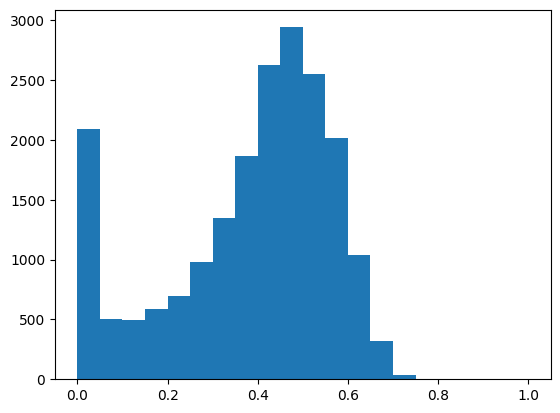

prec_SAR


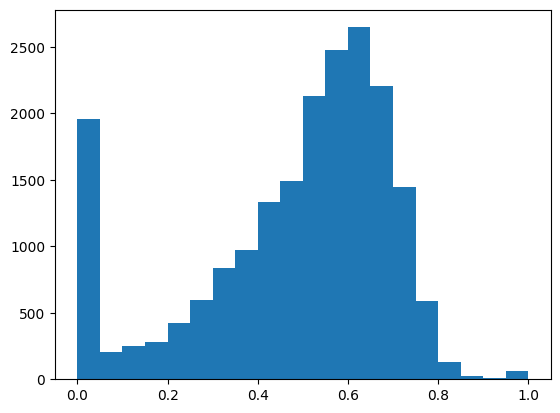

rec_fusion


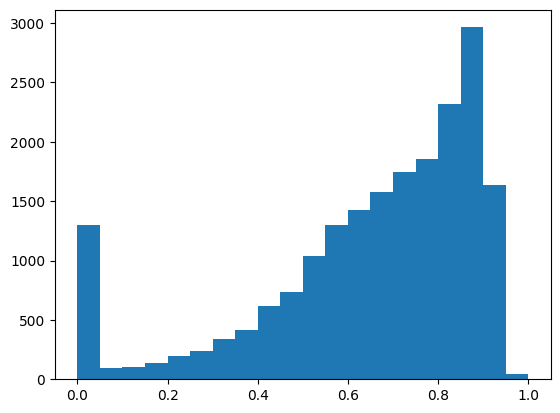

rec_OPT


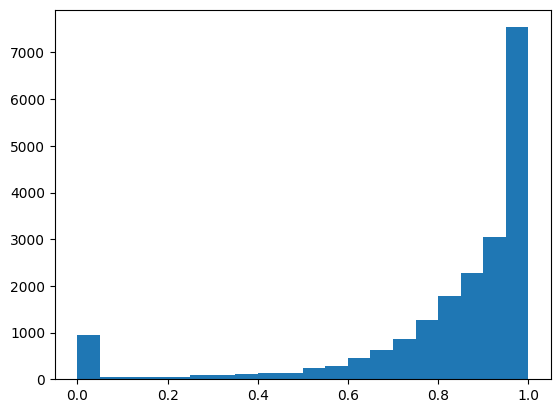

rec_SAR


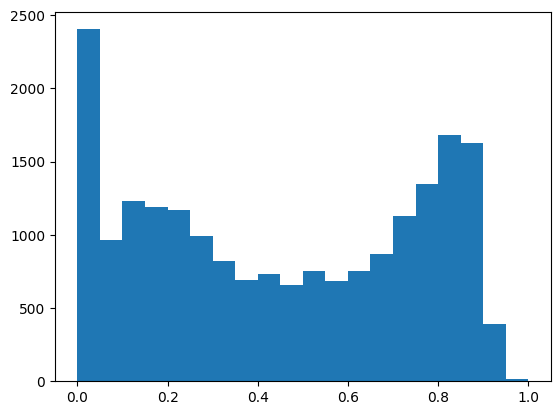

f1_fusion


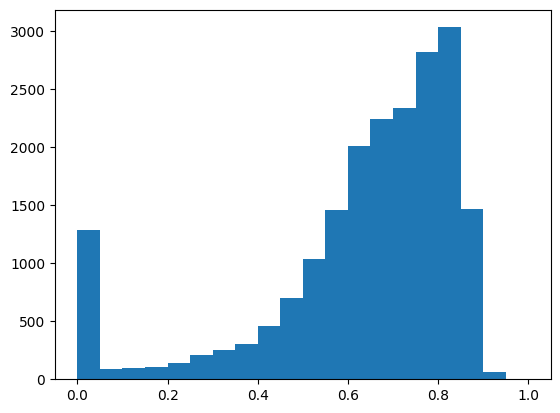

f1_OPT


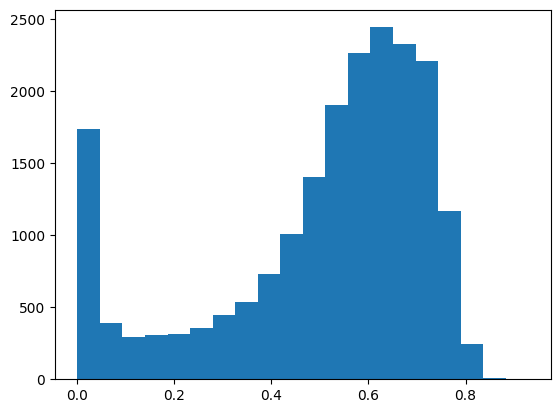

f1_SAR


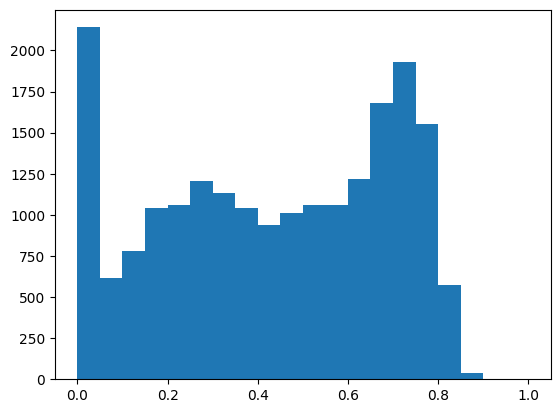

IoU_fusion


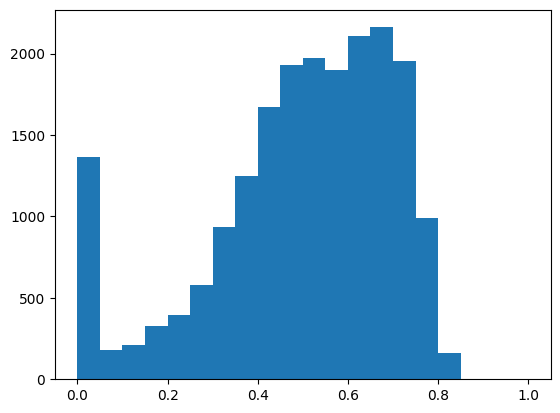

IoU_OPT


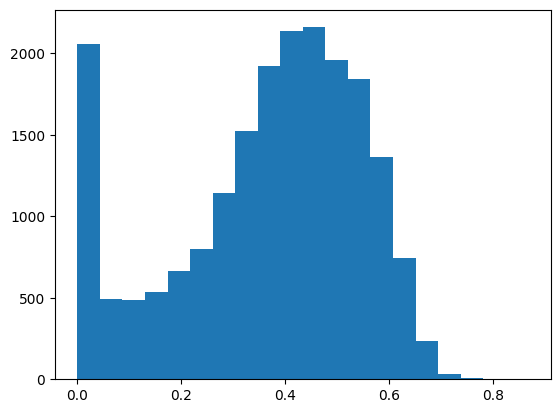

IoU_SAR


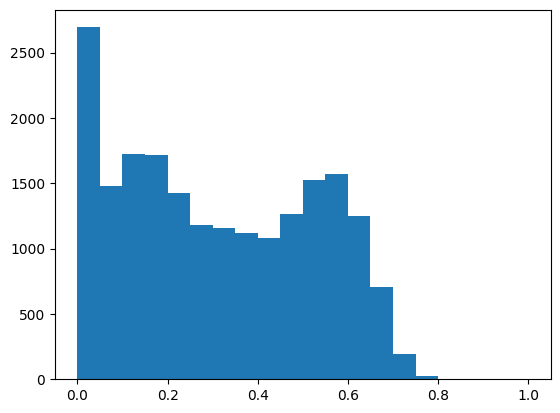

ssim_fusion


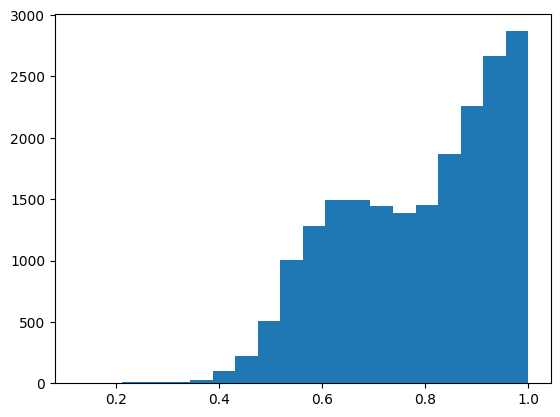

ssim_OPT


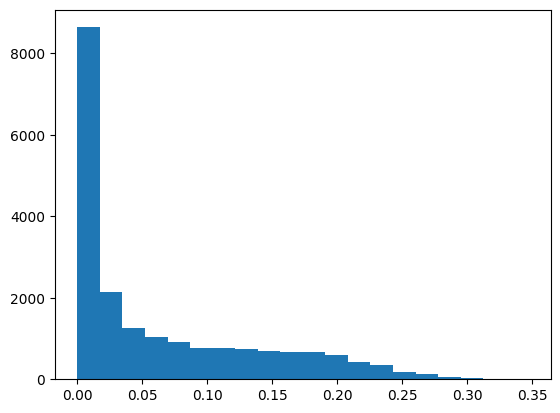

ssim_SAR


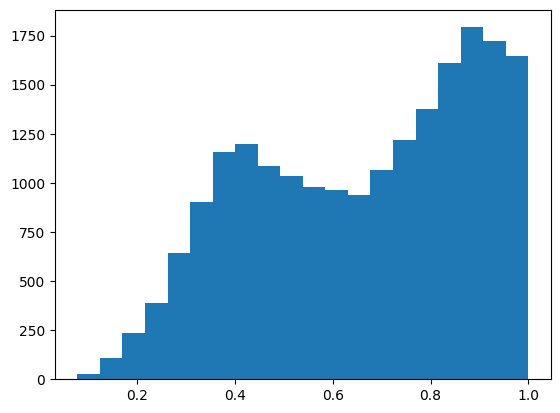

In [86]:
examples_metrics = np.asarray(examples_metrics,  dtype=object)

metrics = ["site", "patch_id","prec_fusion", "prec_OPT", "prec_SAR", "rec_fusion", "rec_OPT", "rec_SAR",
           "f1_fusion","f1_OPT","f1_SAR","IoU_fusion","IoU_OPT","IoU_SAR","ssim_fusion","ssim_OPT","ssim_SAR"]

for i in range(2,examples_metrics.shape[1]):
    print(metrics[i])
    hist, bins = np.histogram(examples_metrics[:,i], bins=20)

    plt.bar(bins[:-1], hist, width=np.diff(bins), align='edge')
    plt.show()

fusion_loss


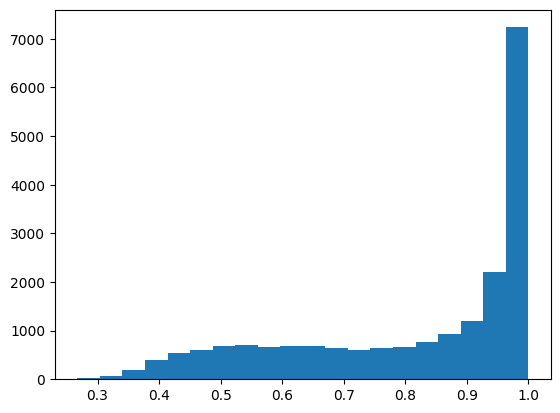

optical_loss


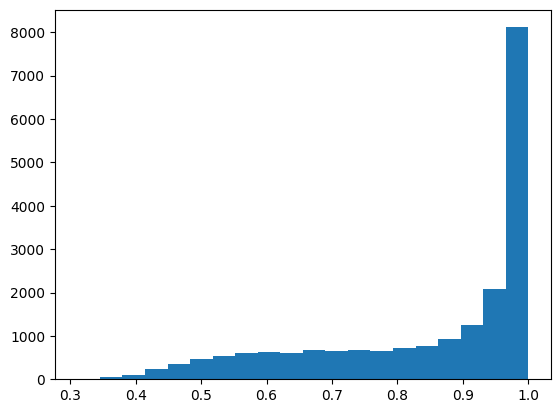

sar_loss


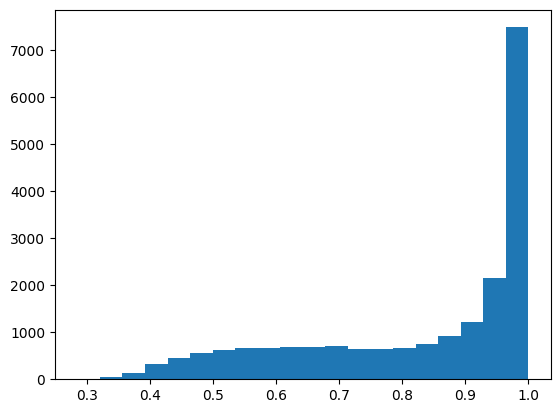

consistency_loss


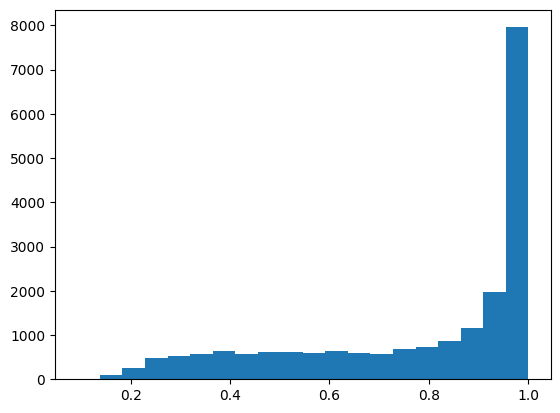

total_loss


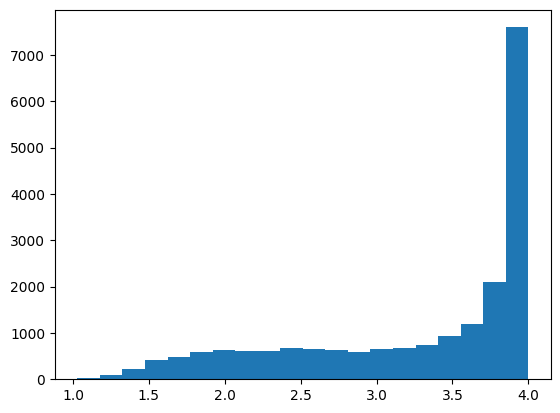

In [87]:
examples_losses = np.asarray(examples_losses,  dtype=object)

metrics = ["site", "patch_id", "fusion_loss", "optical_loss","sar_loss","consistency_loss", "total_loss"]

for i in range(2,examples_losses.shape[1]):
    print(metrics[i])
    hist, bins = np.histogram(examples_losses[:,i], bins=20)

    plt.bar(bins[:-1], hist, width=np.diff(bins), align='edge')
    plt.show()